# Assignment 2 - Part 2
POS Tagging with feed forward Neural Network with 5-fold cross validation

In [1]:
!which python3

/home/development/arif/.conda/envs/stable/bin/python3


In [2]:
! which pip

/home/development/arif/.conda/envs/stable/bin/pip


## Importing Libraries

In [3]:
import nltk
from nltk.corpus import brown
import numpy as np
import torch
import random
import os
from torch import nn
from tqdm import tqdm

Seeding randomness

In [4]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
random.seed(seed)

In [5]:
len(brown.sents())

57340

In [6]:
len(set(brown.words()))

56057

In [136]:
dataset = brown.tagged_sents(tagset='universal')
print(len(dataset))
for sent in dataset[:1]:
    print(sent)

57340
[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')]


## Data Exploration

In [8]:
import re, string, unicodedata
import nltk
import contractions
import inflect
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer


def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    return words

In [9]:
_, tags = zip(*[pair for sent in dataset for pair in sent])
universal_tags = list(set(tags))
del tags
print(f"POS tags are:\n{universal_tags}\nNumber of POS tags are: {len(universal_tags)}")

POS tags are:
['PRT', 'NUM', 'VERB', 'ADP', 'CONJ', 'PRON', 'X', 'ADV', 'ADJ', '.', 'NOUN', 'DET']
Number of POS tags are: 12


In [10]:
from nltk.tag import untag

Seperating sentences and their tags

In [11]:
sentences = [untag(sent) for sent in dataset]
pos_tags = [list(list(zip(*sent))[1]) for sent in dataset]

len(sentences), len(pos_tags)

(57340, 57340)

Looking at data

In [12]:
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = dataset.iloc[picks]
    display(HTML(df.to_html()))

In [13]:
df = pd.DataFrame.from_dict({
    "sentences" : sentences,
    "pos_tags" : pos_tags
})
show_random_elements(df)

,sentences,pos_tags
41905,"[When, Linda, Kay, had, put, up, her, breakfast, dishes, and, mopped, her, linoleum, rugs, ,, she, would, go, to, the, Big, House, .]","[ADV, NOUN, NOUN, VERB, VERB, PRT, DET, NOUN, NOUN, CONJ, VERB, DET, NOUN, NOUN, ., PRON, VERB, VERB, ADP, DET, ADJ, NOUN, .]"
7296,"[The, critics', campaign, finally, inspired, the, first, major, U.S., exhibit, of, Schiele's, works, .]","[DET, NOUN, NOUN, ADV, VERB, DET, ADJ, ADJ, NOUN, NOUN, ADP, NOUN, NOUN, .]"
1639,"[You, can, get, into, an, argument, about, fallout, shelters, at, the, drop, of, a, beer, stein, in, clubs, and, pubs, these, nights, .]","[PRON, VERB, VERB, ADP, DET, NOUN, ADP, NOUN, NOUN, ADP, DET, NOUN, ADP, DET, NOUN, NOUN, ADP, NOUN, CONJ, NOUN, DET, NOUN, .]"
48598,"[``, To, me, you'll, always, be, the, girl, o', my, dreams, ,, an', the, sweetest, flower, that, grows, '', .]","[., ADP, PRON, PRT, ADV, VERB, DET, NOUN, ADP, DET, NOUN, ., CONJ, DET, ADJ, NOUN, DET, VERB, ., .]"
18024,"[Another, poultice, was, made, from, the, inner, bark, of, the, elm, tree, ,, steeped, in, water, until, it, formed, a, sticky, ,, gummy, solution, .]","[DET, NOUN, VERB, VERB, ADP, DET, ADJ, NOUN, ADP, DET, NOUN, NOUN, ., VERB, ADP, NOUN, ADP, PRON, VERB, DET, ADJ, ., ADJ, NOUN, .]"
16049,"[When, a, husband, is, sexually, selfish, and, heedless, of, his, wife's, desires, ,, she, is, cheated, of, the, fulfillment, and, pleasure, nature, intended, for, her, .]","[ADV, DET, NOUN, VERB, ADV, ADJ, CONJ, ADJ, ADP, DET, NOUN, NOUN, ., PRON, VERB, VERB, ADP, DET, NOUN, CONJ, NOUN, NOUN, VERB, ADP, PRON, .]"
14628,"[These, include, :, leaves, of, absences, ,, illnesses, ,, and, layoffs, .]","[DET, VERB, ., NOUN, ADP, NOUN, ., NOUN, ., CONJ, NOUN, .]"
9144,"[More, and, more, boats, move, overland, on, wheels, (, 1.8, million, trailers, are, now, in, use, ), and, Midwesterners, taking, long, weekends, can, travel, south, with, their, craft, .]","[ADJ, CONJ, ADJ, NOUN, VERB, ADV, ADP, NOUN, ., NUM, NUM, NOUN, VERB, ADV, ADP, NOUN, ., CONJ, NOUN, VERB, ADJ, NOUN, VERB, VERB, NOUN, ADP, DET, NOUN, .]"
48265,"[Why, had, I, registered, ?, ?]","[ADV, VERB, PRON, VERB, ., .]"
6717,"[At, Khrushchev's, door, ,, therefore, ,, can, be, placed, the, primary, blame, but, also, at, fault, are, those, who, permitted, themselves, to, be, intimidated, .]","[ADP, NOUN, NOUN, ., ADV, ., VERB, VERB, VERB, DET, ADJ, NOUN, CONJ, ADV, ADP, NOUN, VERB, DET, PRON, VERB, PRON, PRT, VERB, VERB, .]"


## Download word vectors

In [14]:
# import urllib.request
# import zipfile

# url = "https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip"
# filename = "crawl-300d-2M.vec.zip"

# # Download the zip file
# urllib.request.urlretrieve(url, filename)

# # Extract the contents of the zip file
# with zipfile.ZipFile(filename, 'r') as zip_ref:
#     zip_ref.extractall('.')

In [15]:
with open("crawl-300d-2M.vec", "r") as vectors_file:
    file_content = vectors_file.read().splitlines()

In [16]:
print(f"1st line in the above file, file_content tells the number of words for which the file has embeddings followed by the dimensions of the embeddings.")
print(file_content[0])

1st line in the above file, file_content tells the number of words for which the file has embeddings followed by the dimensions of the embeddings.
1999995 300


In [17]:
print(f"The rest of the lines have a word at every line followed by 300 numbers for the 300d word embeddings of the word, a sample is shown below.")
print(file_content[424242])

The rest of the lines have a word at every line followed by 300 numbers for the 300d word embeddings of the word, a sample is shown below.
Wreck-It -0.2941 -0.0440 0.6280 0.3474 0.5014 -1.0144 0.5379 -0.2273 -0.0119 -0.2189 0.0294 1.2556 -0.1439 0.2246 0.0659 -0.0031 0.1349 0.3719 -0.5852 -0.3380 0.4387 0.4592 0.3349 -0.4750 -0.3464 0.6705 -0.5252 0.3864 -0.1200 0.1228 -0.1977 0.9876 0.3050 0.2154 0.8681 -0.2432 0.0239 -0.2227 -0.3440 0.5673 0.7380 0.1509 0.0166 0.6669 -0.4747 0.2333 0.0375 0.7208 -0.4009 -0.3855 0.2377 0.2651 1.1744 -0.5010 -0.0412 0.3804 0.2547 0.2091 -0.4663 0.0147 -0.5130 -0.1848 0.1726 0.3357 0.8713 0.7080 0.8966 -0.8118 0.0568 -0.5825 -0.6531 0.2765 -0.1806 0.2960 0.4276 0.3042 -0.2592 0.2431 -0.3561 -0.0708 0.5813 0.2686 0.4225 -0.1953 0.4349 -0.3406 0.0300 -0.5246 -0.1651 -0.4520 0.1233 0.1704 -0.0815 0.2655 -0.2337 -0.4135 -0.0224 0.5407 0.0084 -0.2461 -0.2733 0.2132 -0.0585 -0.1620 0.3127 -0.3421 -0.7229 0.6596 0.4628 -0.2809 -0.4614 0.0984 0.4248 -0.7097 -0.

Making a dictionary mapping from the word to the embedding, called `word2embedding`.

In [18]:
word2embedding = dict()
for line in file_content[1:]:
    word2embedding[line.split()[0]] = torch.tensor(list(map(float, line.split()[1:])))
    
vocab = list(word2embedding.keys())

As `file_content` is a large variable that is no longer needed, we delete it.

In [19]:
del file_content

Checking for duplication is vocabulary `vocab`

In [20]:
len(vocab), len(set(vocab))

(1999995, 1999995)

Notice that same word can have different embeddings for its capitalized and non-capitalized versions.

In [ ]:
word2embedding['The']

In [ ]:
word2embedding['the']

In [23]:
# Looking at data type of embedding to be sure
word2embedding['the'].dtype

torch.float32

Checking if we have word embeddings for individual letters and symbols

In [24]:
import string

list_of_all = [x for x in string.punctuation] + [x for x in string.digits] + [x for x in string.ascii_letters]
not_present = list()
for item in list_of_all:
    if item not in vocab:
        not_present.append(item)

print(f"We have following individual characters:\n{list_of_all}\nfrom which only characters {not_present} donot have embeddings in word2embedding.")

We have following individual characters:
['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
from which only characters ['_', '`'] donot have embeddings in word2embedding.


## Preparing data for training

In [27]:
# Make device agnostic code
device = "cuda:3" if torch.cuda.is_available() else "cpu"
print(device)

cuda:3


In [28]:
window_size = 1
X = list()
y = list()

null_token = "[NULL_TOKEN]"
for sentence, pos_tags in zip(sentences, pos_tags):
    for i in range(len(sentence)):
        y.append(pos_tags[i])
        padded_sentence = [null_token] * window_size + sentence + [null_token] * window_size
        X.append(padded_sentence[i : i + 2*window_size + 1])

In [29]:
X[:5], y[:5]

([['[NULL_TOKEN]', 'The', 'Fulton'],
  ['The', 'Fulton', 'County'],
  ['Fulton', 'County', 'Grand'],
  ['County', 'Grand', 'Jury'],
  ['Grand', 'Jury', 'said']],
 ['DET', 'NOUN', 'NOUN', 'ADJ', 'NOUN'])

Setting `[NULL_TOKEN]` embeddings as all zeros

In [30]:
word2embedding[null_token] = torch.zeros_like(word2embedding['The'])

In [ ]:
word2embedding[null_token], word2embedding[null_token].dtype

### Code for handling embeddings of words not in the word embeddings file

In [32]:
import re

def decontracted(phrase):
    # general
    phrase = re.sub(r"n\'t", "", phrase)
    phrase = re.sub(r"\'re", "", phrase)
    phrase = re.sub(r"\'s", "", phrase)
    phrase = re.sub(r"\'d", "", phrase)
    phrase = re.sub(r"\'ll", "", phrase)
    phrase = re.sub(r"\'t", "", phrase)
    phrase = re.sub(r"\'ve", "", phrase)
    phrase = re.sub(r"\'m", "", phrase)
    phrase = re.sub(r"\'$", "", phrase)
    return phrase


test = "Hey I'm Yann, how're you and how's it going ? That's interesting: I'd love to hear more about it."
print(decontracted(test))

Hey I Yann, how you and how it going ? That interesting: I love to hear more about it.


In [33]:
word2embedding["``"] = word2embedding["'"]
word2embedding["''"] = word2embedding["'"]
word2embedding[not_present[0]] = word2embedding["-"]

In [34]:
import re
# Define a regular expression pattern
# Pattern to check if a number only has digits, dollar signs, and commas.

non_alphabet_pattern = r'^[^a-zA-Z]+$'
non_alphabet_word_list = []
for word in list(word2embedding.keys()):
    if re.match(non_alphabet_pattern, word):
        # print(word)
        non_alphabet_word_list.append(word)

word2embedding["[NON_ALPHABET]"] = torch.mean(
    torch.stack([word2embedding[num] for num in non_alphabet_word_list]), 
    dim=0
    )

In [ ]:
non_alphabet_word_list

In [ ]:
word2embedding["[NON_ALPHABET]"], word2embedding["[NON_ALPHABET]"].shape

A sample of how we'll use subwords seperated by puctuations to find embeddings of large compund words, not present in `vocab`

In [37]:
letters = list("ex-Mrs.")
punctuations = [x for x in string.punctuation]
positions = [i for i, x in enumerate(letters) if x in punctuations]

print(letters)
print(positions)

sub_words = []
for i, j in zip([0] + positions, positions + [None]):
    if i==0:
        sub_words.append("".join(letters[i:j]))
    else:
        sub_words.append(letters[i])
        sub_words.append("".join(letters[i+1:j]))
    
while "" in sub_words:
    sub_words.remove("")
print(sub_words)

sub_words_embeddings = []
for sub_word in sub_words:
    sub_words_embeddings.append(word2embedding[sub_word])

print(torch.mean(torch.stack(sub_words_embeddings), dim=0))

['e', 'x', '-', 'M', 'r', 's', '.']
[2, 6]
['ex', '-', 'Mrs', '.']
tensor([ 7.9575e-02, -3.7300e-02, -2.1530e-01, -1.4200e-02, -1.6500e-03,
        -1.2237e-01,  1.7050e-01, -4.2400e-02, -5.5150e-02, -7.7375e-02,
        -6.5125e-02,  2.7000e-01, -2.2225e-02, -2.6000e-03, -4.0350e-02,
        -5.8175e-02, -2.6825e-02,  1.0875e-02, -8.1950e-02,  9.5975e-02,
         3.1750e-03,  2.5700e-02, -9.6450e-02, -1.6780e-01, -2.9275e-02,
        -3.0750e-03,  5.5250e-03,  7.0350e-02,  9.0525e-02,  1.4958e-01,
         3.6800e-02, -3.3500e-02, -1.0813e-01,  1.6862e-01, -1.0500e-01,
        -3.1500e-02, -5.7125e-02,  0.0000e+00, -3.2725e-02, -6.4325e-02,
        -9.5225e-02, -3.7150e-02,  1.3418e-01,  1.0030e-01,  1.9827e-01,
         3.7025e-02, -1.5350e-02, -7.5175e-02, -6.0300e-02, -2.5732e-01,
        -5.3400e-02,  7.7875e-02,  2.9350e-02, -2.5450e-02,  1.7875e-02,
        -9.3400e-02, -6.8050e-02,  2.2273e-01,  6.0375e-02,  2.5000e-04,
        -7.0575e-02,  1.9107e-01,  4.5425e-02, -7.5250e-0

In [38]:
import string
punctuations = [x for x in string.punctuation]

word2embedding["[UNK]"] = torch.mean(torch.stack([embedding for _, embedding in word2embedding.items()]), dim=0)

set_of_vocab = set(word2embedding.keys())

def get_embeddings(word, word2embedding, words_not_present):
    if word in word2embedding.keys():
        return word2embedding[word]
    elif re.match(non_alphabet_pattern, word):
        return word2embedding["[NON_ALPHABET]"]
    elif decontracted(word) in word2embedding.keys():
        return word2embedding[decontracted(word)]
    elif decontracted(word).lower() in word2embedding.keys():
        return word2embedding[decontracted(word).lower()]
    else:
        letters = list(word)
        positions = [i for i, x in enumerate(letters) if x in punctuations]

        sub_words = []
        for i, j in zip([0] + positions, positions + [None]):
            if i==0:
                sub_words.append("".join(letters[i:j]))
            else:
                sub_words.append(letters[i])
                sub_words.append("".join(letters[i+1:j]))
            
        while "" in sub_words:
            sub_words.remove("")
        
        if set(sub_words).issubset(set_of_vocab):
            return torch.mean(torch.stack([get_embeddings(sub_word, word2embedding, words_not_present) for sub_word in sub_words]), dim=0)
        else:
            words_not_present.append(word)
            return word2embedding["[UNK]"]
            # words_embeddings.append(word2embedding[word])

In [39]:
words_not_present = list()

X_embeddings = list()
for words in tqdm(X):
    words_embeddings = list()
    for word in words:
        words_embeddings.append(get_embeddings(word, word2embedding, words_not_present))
    X_embeddings.append(torch.stack(words_embeddings))

X_embeddings = torch.stack(X_embeddings)

100%|██████████| 1161192/1161192 [00:12<00:00, 96309.46it/s] 


In [40]:
with open("words_not_present.txt", "w") as f:
    for word in words_not_present:
        f.write(f"{word}\n")

In [41]:
len(words_not_present)

7165

In [42]:
len(set(words_not_present))

1703

In [43]:
vocab = list(word2embedding.keys())
len(vocab), len(set(vocab))

(2000001, 2000001)

A dictionary to convert pos tags to ids

In [44]:
pos_tag_to_id = dict()
for i, tag in enumerate(sorted(universal_tags)):
    pos_tag_to_id[tag] = i

In [45]:
pos_tag_to_id

{'.': 0,
 'ADJ': 1,
 'ADP': 2,
 'ADV': 3,
 'CONJ': 4,
 'DET': 5,
 'NOUN': 6,
 'NUM': 7,
 'PRON': 8,
 'PRT': 9,
 'VERB': 10,
 'X': 11}

In [46]:
len(X_embeddings), len(y)

(1161192, 1161192)

Actual conversion of labels (pos tags) to ids below:

In [47]:
for i in range(len(y)):
    y[i] = torch.tensor(pos_tag_to_id[y[i]])

In [48]:
y = torch.stack(y)

In [49]:
y.dtype

torch.int64

In [50]:
y[0].dtype

torch.int64

In [51]:
len(X), len(y)

(1161192, 1161192)

In [52]:
X_embeddings.shape, y.shape

(torch.Size([1161192, 3, 300]), torch.Size([1161192]))

## Creating POS-Tagger Model class

In [53]:
# Construct a model that subclasses NN.Module

class POS_tagger(nn.Module):
    def __init__(self, embedding_size, window_size, hidden_layer_size, num_tags, device):
        super().__init__()
        
        self.embedding_size = embedding_size
        self.window_size = window_size
        self.device = device
        self.layers_embeddigs_to_hidden = nn.ModuleList([nn.Linear(in_features=embedding_size, out_features=hidden_layer_size, bias=True) for _ in range(2*window_size + 1)])
        self.activation = nn.ReLU()
        self.layer_hidden_to_output = nn.Linear(in_features=hidden_layer_size, out_features=num_tags, bias=True)
        # self.output_probabilities = nn.Softmax(dim=1)
        
        
        
    # Define a `forward()` method that outlines the forward pass (or forward computation) of the model
    def forward(self, batched_embeddings):
        inputs_to_hidden = torch.stack([
            torch.stack([layer(embedding) for embedding, layer in zip(embeddings, self.layers_embeddigs_to_hidden)])
            for embeddings in batched_embeddings
            ]).to(self.device)
        return self.layer_hidden_to_output(self.activation(torch.mean(inputs_to_hidden, dim=1)))
        # return self.output_probabilities(self.layer_embeddigs_to_word(self.layer_context_to_embeddings(context_embeddings_average))) 

In [54]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()      # torch.eq(y_true, y_pred) checks how many of y_true are actually equal to y_pred
    accuracy = correct / len(y_pred) * 100
    return accuracy

In [55]:
id_to_pos_tag = {id: tag for tag, id in pos_tag_to_id.items()}
id_to_pos_tag

{0: '.',
 1: 'ADJ',
 2: 'ADP',
 3: 'ADV',
 4: 'CONJ',
 5: 'DET',
 6: 'NOUN',
 7: 'NUM',
 8: 'PRON',
 9: 'PRT',
 10: 'VERB',
 11: 'X'}

## Stratified K-fold cross valiation training
(without shuffling, as we do that in training loop)

Data Preparation + Training loop below

In [70]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=2)

per_fold_test_predictions = list()
per_fold_test_labels = list()

for j, (train_index, test_index) in enumerate(kf.split(X, y)):
    print(f"\n\nK-Fold Split that is running: {j}")
    X_train = torch.index_select(X_embeddings, 0, torch.LongTensor(train_index))
    X_test = torch.index_select(X_embeddings, 0, torch.LongTensor(test_index))
    y_train = torch.index_select(y, 0, torch.LongTensor(train_index))
    y_test = torch.index_select(y, 0, torch.LongTensor(test_index))
    
    # Set the number of epochs
    epochs = 4

    # Put the data on the target device
    X_train, y_train = X_train.to(device), y_train.to(device)
    X_test, y_test = X_test.to(device), y_test.to(device)
    
    pos_tagger = POS_tagger(embedding_size=300, window_size=1, hidden_layer_size=128, num_tags=len(universal_tags), device=device).to(device)
    
    # Create a loss function
    loss_fn = nn.CrossEntropyLoss() # CrossEntropyLoss -> sigmoid activation is built-in

    # Create an optimizer
    optimizer = torch.optim.Adam(params=pos_tagger.parameters(),
                                lr = 1e-3)
    
    batch_size = 512
    # Building the training and evaluation loop
    for epoch in range(epochs):
        epoch_loss = 0.0
        ## Training
        pos_tagger.train()
        with tqdm(np.random.permutation(range(0, len(X_train), batch_size))) as progress_bar:
            for i in progress_bar:
                # 1. Forward pass
                y_logits = pos_tagger(X_train[i:i+batch_size]).squeeze()      # squeeze removes an extra one dimension from a tensor
                # y_pred = torch.argmax(torch.nn.Softmax(y_logits), dim=1)   # Can't make it work with sotmax for some reason
                y_pred = torch.argmax(y_logits, dim=1)
            
                # 2. Calculate loss / accuracy
                loss = loss_fn(y_logits,        # nn.CrossEntropyLoss expects raw logits as input
                            y_train[i:i+batch_size])
            
                epoch_loss += loss
                
                acc = accuracy_fn(y_true=y_train[i:i+batch_size],
                                y_pred=y_pred)
            
                # 3. Optimizer zero grad
                optimizer.zero_grad()
            
                # 4. Loss backward (back propagation)
                loss.backward()
            
                # 5. Optimizer step (gradient descent)
                optimizer.step()
                
                progress_bar.set_postfix(batch_loss=loss.item())
            
            
            ### Testing
            pos_tagger.eval()
            with torch.inference_mode():
                # 1. Forward pass
                test_logits = pos_tagger(X_test).squeeze()      # squeeze removes an extra one dimension from a tensor
                test_pred = torch.argmax(test_logits, dim=1)
                
                # 2. Calculate loss / accuracy
                test_loss = loss_fn(test_logits,        # nn.CrossEntropyLoss expects raw logits as input
                                    y_test)
                
                test_acc = accuracy_fn(y_true=y_test,
                                y_pred=test_pred)
                
        
        # if epoch % 10 == 0:    
        print(f"Epoch: {epoch} | Train Loss: {loss:.5f} | Train Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")
            
    per_fold_test_predictions.append(test_pred)
    per_fold_test_labels.append(y_test)



K-Fold Split that is running: 0


100%|██████████| 1134/1134 [02:52<00:00,  6.56it/s, batch_loss=0.116] 


Epoch: 0 | Train Loss: 0.11637 | Train Acc: 96.29% | Test Loss: 0.13657 | Test Acc: 96.00%


100%|██████████| 1134/1134 [02:54<00:00,  6.50it/s, batch_loss=0.0801]


Epoch: 1 | Train Loss: 0.08014 | Train Acc: 97.66% | Test Loss: 0.11132 | Test Acc: 96.53%


100%|██████████| 1134/1134 [03:00<00:00,  6.28it/s, batch_loss=0.096] 


Epoch: 2 | Train Loss: 0.09601 | Train Acc: 96.88% | Test Loss: 0.09817 | Test Acc: 96.91%


100%|██████████| 1134/1134 [02:55<00:00,  6.47it/s, batch_loss=0.0541]


Epoch: 3 | Train Loss: 0.05414 | Train Acc: 98.63% | Test Loss: 0.09048 | Test Acc: 97.11%


K-Fold Split that is running: 1


100%|██████████| 1134/1134 [02:59<00:00,  6.33it/s, batch_loss=0.143] 


Epoch: 0 | Train Loss: 0.14321 | Train Acc: 95.90% | Test Loss: 0.14208 | Test Acc: 95.97%


100%|██████████| 1134/1134 [02:56<00:00,  6.42it/s, batch_loss=0.0841]


Epoch: 1 | Train Loss: 0.08408 | Train Acc: 96.68% | Test Loss: 0.11520 | Test Acc: 96.59%


100%|██████████| 1134/1134 [02:45<00:00,  6.86it/s, batch_loss=0.0828]


Epoch: 2 | Train Loss: 0.08278 | Train Acc: 97.07% | Test Loss: 0.10407 | Test Acc: 96.89%


100%|██████████| 1134/1134 [02:57<00:00,  6.39it/s, batch_loss=0.0874]


Epoch: 3 | Train Loss: 0.08736 | Train Acc: 97.07% | Test Loss: 0.09542 | Test Acc: 97.14%


### Helper functions to accumulate and display results of K-fold cross validation

In [137]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support, fbeta_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def get_results_classification(y_true, y_pred, labels, id_to_label, normalized=False):
    y_pred_labels = [id_to_label[i] for i in y_pred.cpu().detach().numpy()]
    y_true_labels = [id_to_label[i] for i in y_true.cpu().detach().numpy()]
    
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_true_labels, y_pred_labels, average='macro')
    print(f"""Overall performance:
                precision = {precision} \t recall = {recall} \t f1-score = {f1_score}\n 
          """)
    print(classification_report(y_true_labels, y_pred_labels, target_names=labels))

    if normalized:
        normalized = 'true'
    else:
        normalized = None    

    cm = confusion_matrix(y_true_labels, y_pred_labels, labels=labels, normalize=normalized)
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(10, 10))
    display.plot(ax=ax, xticks_rotation="vertical")
    plt.show()

In [72]:
def get_confusion_matrix(y_true, y_pred, labels, id_to_label, normalized=False):
    y_pred_labels = [id_to_label[i] for i in y_pred.cpu().detach().numpy()]
    y_true_labels = [id_to_label[i] for i in y_true.cpu().detach().numpy()]

    if normalized:
        normalized = 'true'
    else:
        normalized = None    

    return confusion_matrix(y_true_labels, y_pred_labels, labels=labels, normalize=normalized)

In [73]:
def plot_confusion_matrix(cm, labels):
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(10, 10))
    display.plot(ax=ax, xticks_rotation="vertical")
    plt.show()

In [74]:
def get_overall_metrics(y_true, y_pred, labels, id_to_label):
    y_pred_labels = [id_to_label[i] for i in y_pred.cpu().detach().numpy()]
    y_true_labels = [id_to_label[i] for i in y_true.cpu().detach().numpy()]
    
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_true_labels, y_pred_labels, average='macro')
    
    f_0_5_score = fbeta_score(y_true_labels, y_pred_labels, beta = 0.5, average='macro')
    f_2_score = fbeta_score(y_true_labels, y_pred_labels, beta = 2, average='macro')
    
    return np.array([precision, recall, f1_score, f_0_5_score, f_2_score])

In [83]:
def get_classification_report(y_true, y_pred, labels, id_to_label):
    y_pred_labels = [id_to_label[i] for i in y_pred.cpu().detach().numpy()]
    y_true_labels = [id_to_label[i] for i in y_true.cpu().detach().numpy()]
    
    return classification_report(y_true_labels, y_pred_labels, target_names=labels, output_dict = True)

In [138]:
def get_overall_results(reports):
    overall_results = {key: {} if key != 'accuracy' else 0 for key in reports[0].keys()}
    
    # Initialize an empty dictionary with the same structure as report
    overall_results = {key: {} if key != 'accuracy' else 0 for key in reports[0].keys()}

    # Loop over all the reports and accumulate the values
    for r in reports:
        for key, value in r.items():
            if key == 'accuracy':
                overall_results['accuracy'] = 0.0
            else:
                overall_results[key]['precision'] = 0.0
                overall_results[key]['recall'] = 0.0
                overall_results[key]['f1-score'] = 0.0
                overall_results[key]['support'] = 0.0

    # Loop over all the reports and accumulate the values
    for r in reports:
        for key, value in r.items():
            if key == 'accuracy':
                overall_results['accuracy'] += r['accuracy']
            else:
                overall_results[key]['precision'] += value['precision']
                overall_results[key]['recall'] += value['recall']
                overall_results[key]['f1-score'] += value['f1-score']
                overall_results[key]['support'] += value['support']
        

    # Calculate the averages by dividing the accumulated values by the number of reports
    n_reports = len(reports)
    for key, value in overall_results.items():
        if key == 'accuracy':
            overall_results['accuracy'] /= n_reports
        else:
            value['precision'] /= n_reports
            value['recall'] /= n_reports
            value['f1-score'] /= n_reports
            value['support'] = int(round(value['support'] / n_reports))
            
    df_results = pd.DataFrame(overall_results).transpose()
    df_results.at["accuracy", "support"] = df_results.at["macro avg", "support"]
    df_results["support"] = df_results["support"].astype(int)
    
    display(HTML(df_results.to_html()))

## Evaluation of predictions from K-fold training

Overall performance:
                precision = 0.9583144758744756 	 recall = 0.9151313732546774 	 f1-score = 0.929708409063668
 
          
              precision    recall  f1-score   support

           .       1.00      1.00      1.00     69655
         ADJ       0.92      0.92      0.92     44533
         ADP       0.98      0.98      0.98     74178
         ADV       0.95      0.91      0.93     26828
        CONJ       0.99      0.99      0.99     19029
         DET       0.99      1.00      0.99     69824
        NOUN       0.96      0.98      0.97    146397
         NUM       0.97      0.95      0.96      7830
        PRON       0.98      0.98      0.98     20546
         PRT       0.94      0.93      0.93     13405
        VERB       0.98      0.96      0.97     87637
           X       0.84      0.39      0.53       734

    accuracy                           0.97    580596
   macro avg       0.96      0.92      0.93    580596
weighted avg       0.97      0.97      0.97   

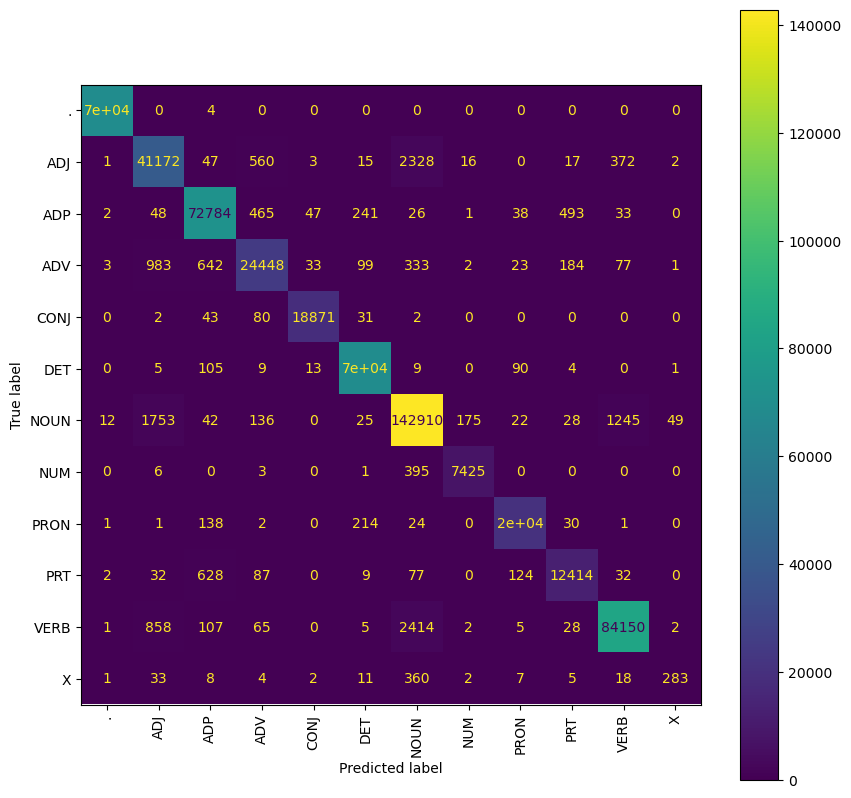

Overall performance:
                precision = 0.9469166766993206 	 recall = 0.9217906017036825 	 f1-score = 0.931347713266134
 
          
              precision    recall  f1-score   support

           .       1.00      1.00      1.00     77910
         ADJ       0.93      0.91      0.92     39188
         ADP       0.97      0.98      0.98     70588
         ADV       0.94      0.92      0.93     29411
        CONJ       0.99      1.00      0.99     19122
         DET       0.99      0.99      0.99     67195
        NOUN       0.97      0.97      0.97    129161
         NUM       0.96      0.98      0.97      7044
        PRON       0.96      0.99      0.97     28788
         PRT       0.92      0.90      0.91     16424
        VERB       0.98      0.97      0.98     95113
           X       0.75      0.46      0.57       652

    accuracy                           0.97    580596
   macro avg       0.95      0.92      0.93    580596
weighted avg       0.97      0.97      0.97   

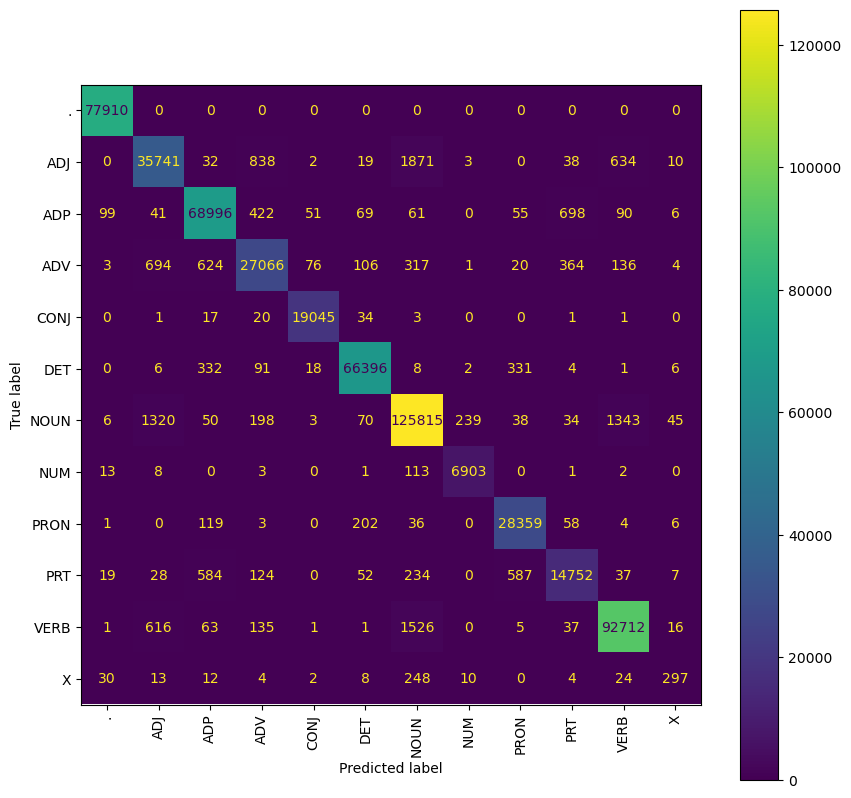

In [76]:
for y_test, test_pred in zip(per_fold_test_labels, per_fold_test_predictions):
    get_results_classification(y_true=y_test, y_pred=test_pred, labels=sorted(universal_tags), id_to_label=id_to_pos_tag, normalized=False)

In [77]:
cm = np.mean([
    get_confusion_matrix(y_true=y_test, y_pred=test_pred, labels=sorted(universal_tags), id_to_label=id_to_pos_tag, normalized=False)
    for y_test, test_pred in zip(per_fold_test_labels, per_fold_test_predictions) 
], axis=0).astype(int)

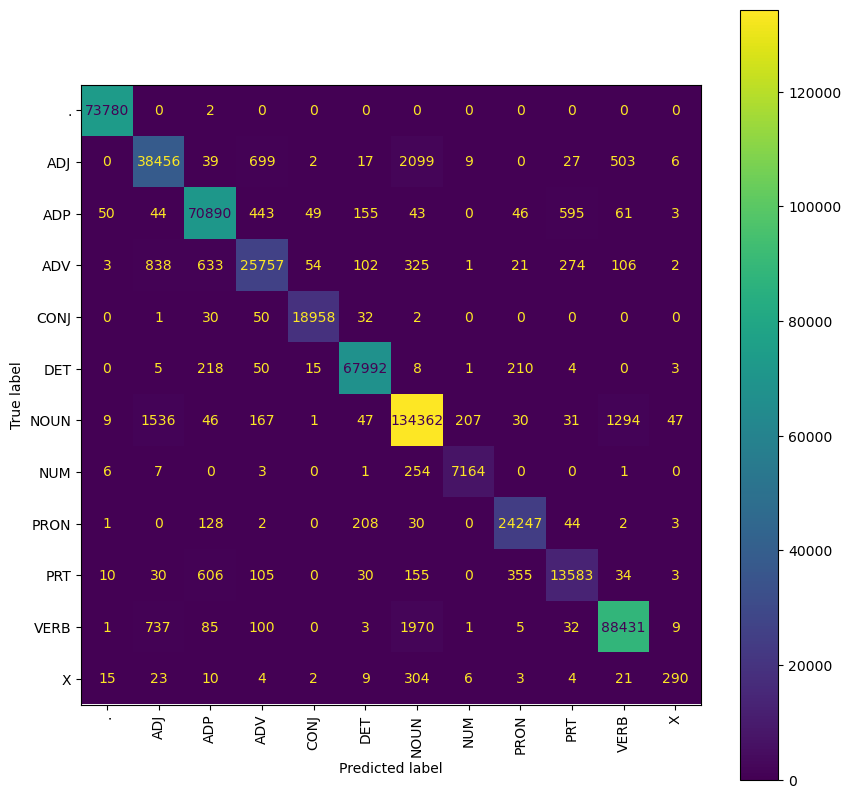

In [78]:
plot_confusion_matrix(cm=cm, labels=sorted(universal_tags))

In [79]:
overall_metrics = np.mean([
    get_overall_metrics(y_true=y_test, y_pred=test_pred, labels=sorted(universal_tags), id_to_label=id_to_pos_tag)
    for y_test, test_pred in zip(per_fold_test_labels, per_fold_test_predictions) 
], axis=0)

In [80]:
print(f"Overall performance of model: \
      \n\tPrecision: {overall_metrics[0]} \
      \n\tRecall: {overall_metrics[1]} \
      \n\tF1-score: {overall_metrics[2]} \
      \n\tF0.5-score: {overall_metrics[3]} \
      \n\tF2-score: {overall_metrics[4]}")

Overall performance of model:       
	Precision: 0.9526155762868981       
	Recall: 0.91846098747918       
	F1-score: 0.9305280611649009       
	F0.5-score: 0.9417824601317095       
	F2-score: 0.9226099030449179


In [94]:
reports = [
    get_classification_report(y_true=y_test, y_pred=test_pred, labels=sorted(universal_tags), id_to_label=id_to_pos_tag)
    for y_test, test_pred in zip(per_fold_test_labels, per_fold_test_predictions) 
]

In [128]:
get_overall_results(reports)

,precision,recall,f1-score,support
.,0.998734,0.999971,0.999352,73782
ADJ,0.923112,0.918284,0.920651,41860
ADP,0.975229,0.979327,0.977274,72383
ADV,0.940923,0.915777,0.928158,28120
CONJ,0.993432,0.993835,0.993630,19076
DET,0.991169,0.992365,0.991761,68510
NOUN,0.962999,0.975138,0.969026,137779
NUM,0.969201,0.964129,0.966548,7437
PRON,0.974821,0.982547,0.978628,24667
PRT,0.931380,0.912135,0.921649,14914


## Code for Demo of POS Tagging

In [130]:
from nltk.tokenize import word_tokenize

In [131]:
def get_pos_tags(sentence):
    tokens = word_tokenize(sentence)
    test = list()

    null_token = "[NULL_TOKEN]"
    for i in range(len(tokens)):
        padded_sentence = [null_token] * window_size + tokens + [null_token] * window_size
        test.append(padded_sentence[i : i + 2*window_size + 1])
    
    test_embeddings = list()
    words_not_present = list()

    for words in test:
        words_embeddings = list()
        for word in words:
            words_embeddings.append(get_embeddings(word, word2embedding, words_not_present))
        test_embeddings.append(torch.stack(words_embeddings))

    test_embeddings = torch.stack(test_embeddings)
    
    pos_tagger.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = pos_tagger(test_embeddings.to(device)).squeeze()      # squeeze removes an extra one dimension from a tensor
        test_pred = torch.argmax(test_logits, dim=1)
        
    test_pred = [id_to_pos_tag[id] for id in test_pred.cpu().detach().numpy()]
    
    df_test = pd.DataFrame.from_dict({
        "tokens": tokens,
        "POS Tags": test_pred
    })
    
    display(HTML(df_test.to_html()))

Sample input sentence:

Good muffins cost $3.88 in New York. Please buy me ... two of them. Thanks.

In [132]:
sentence = input("Please enter sentence to perform POS Tagging:\n")

In [133]:
get_pos_tags(sentence)

,tokens,POS Tags
0,Good,ADJ
1,muffins,NOUN
2,cost,VERB
3,$,NOUN
4,3.88,NUM
5,in,ADP
6,New,ADJ
7,York,NOUN
8,.,.
9,Please,NOUN


In [134]:
sentence = "Let's watch cricket. But don't mind my friend who does not watch cricket but pretends to."
get_pos_tags(sentence)

,tokens,POS Tags
0,Let,VERB
1,'s,VERB
2,watch,VERB
3,cricket,NOUN
4,.,.
5,But,CONJ
6,do,VERB
7,n't,NOUN
8,mind,VERB
9,my,DET
